# Exercise Sheet 3: Head Modeling & Non-linear dynamics

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as signal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, colors
def logistic(h,a=1):
    return 1/(1+np.exp(-a*h))

## Task 1: BEM vs infinite solution  (5 points)


The file 'cortex2dsm.npy', lets call it again $L$ is similar to the leadfields of the last sheet but this time mapping to the cortex surface. Again, you have to select a dipole and the dipolar moments $q$. The voltage is then calculated by $v=L_i \cdot q$.

**Tasks:**

a) Chose an arbitrary dipole and a dipolar moment yourself and simulate the field using the BEM head model.

b) Then, calculate the anayltical solution for an infinite homogeneous current dipole at the cortex surface vertices (positions) for the same source location and dipolar moment. Source conductivity is $\sigma_1=0.201$. You can find the source position $r_q$ for the dipole in 'gridpos.npy' which has the same indexing as the leadfield.

c) Plot the distribution of the potential on the brain surface using the *plot_trisurf* function similar as in task 7 sheet 2 in combination with indiviudally colored triangles.

c) Also, use the simple *plot* function to plot the voltage for both the analytic solution in infiinite space and the BEM soution on the cortex surface over the vertex index to get a closer look at individual values.

Are the solutions equal? Investigate and explain the difference. 

In [14]:
def phi_dip(r, Q, r_0=None,sigma=0.33):
    r=np.array(r)
    Q=np.array(Q)    
    if r_0 is not None:
        r_0=np.array(r_0)
        r=(r-r_0).T
    return 1/(4*np.pi*sigma)*(np.tensordot(Q,r,1))/np.power(np.linalg.norm(r,axis=0),3)

pos1=np.load('bnd4_pos1.npy')
tri1=np.load('bnd4_tri1.npy')

cortex2dsm=np.load('cortex2dsm.npy')
gridpos=np.load('gridpos.npy') #gridposi location of the source
pos1=np.load('bnd4_pos1.npy') #location of the cortex 
tri1=np.load('bnd4_tri1.npy')
NoTri=tri1.shape[0]
NoPnt=pos1.shape[0]

In [23]:
##Define a arbitrary Dipole and a dipolar moment and simulate the field
n_source = 500
Q=np.array([20,0, 0])*1e-15
Li = cortex2dsm[:, n_source, :]

v = Li@Q.T

In [24]:
sigma1 = 0.201
Phi_analytical = phi_dip(pos1, Q, r_0=gridpos[n_source, :], sigma = sigma1)

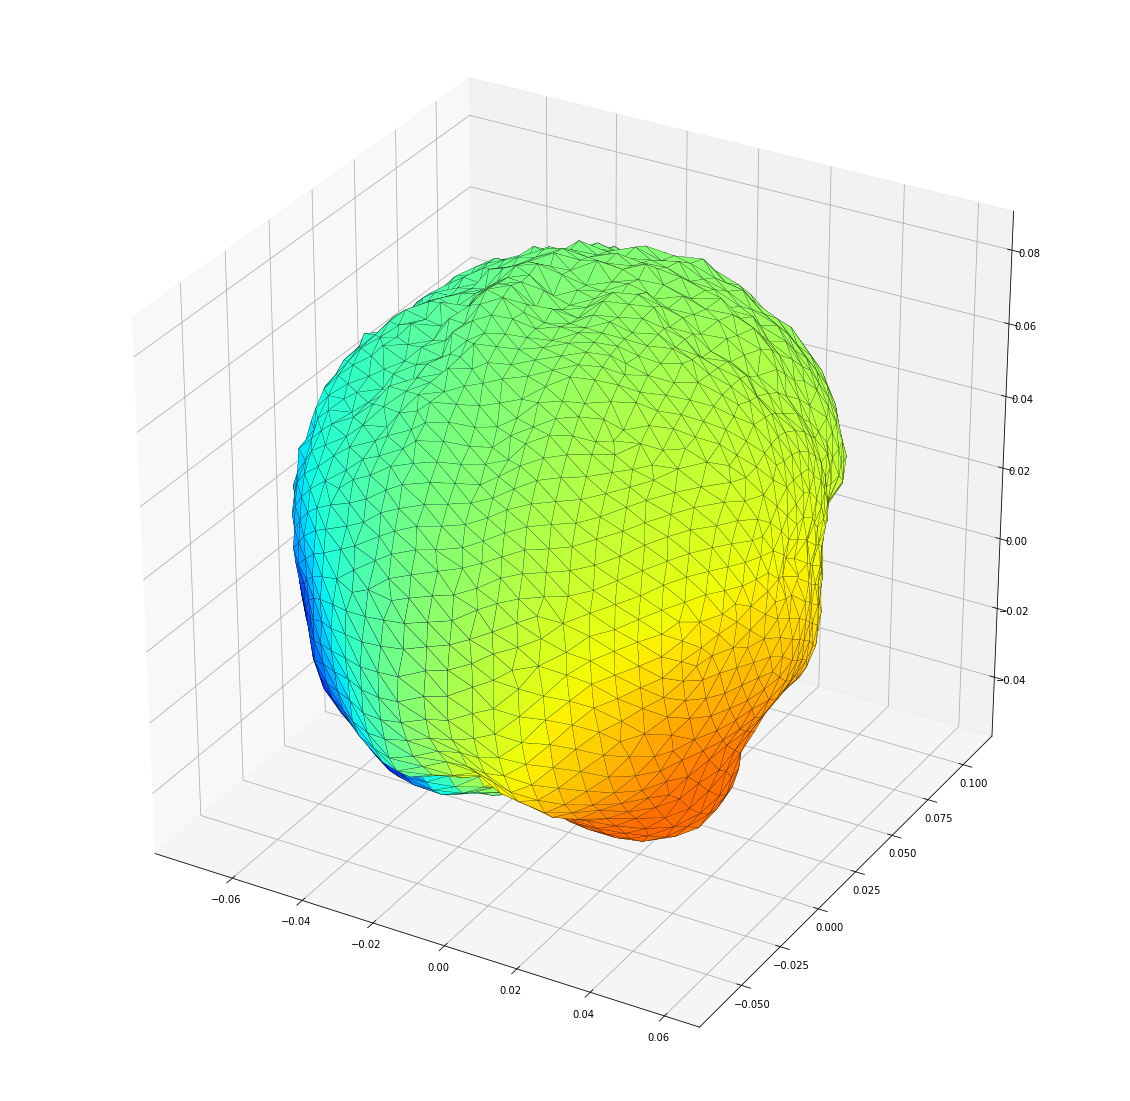

In [25]:
absmax=np.max(np.abs([v]))
mappy=plt.cm.ScalarMappable(cmap=plt.cm.jet)
mappy.set_clim([-absmax,absmax])
trian_colors = np.mean(v[tri1], axis =1)
mappy.set_array(trian_colors)


fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111, projection='3d')
trisurfplot = ax.plot_trisurf(pos1[:, 0], pos1[:, 1],pos1[:, 2], triangles = tri1, linewidth=0.2, edgecolor = 'black', antialiased=True)
trisurfplot.set_facecolors(mappy.to_rgba(trian_colors))

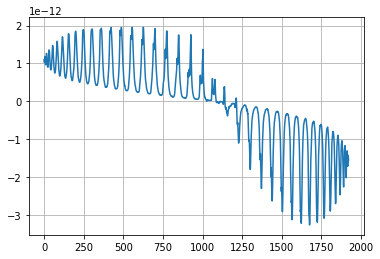

In [26]:
plt.plot(v)
plt.grid()


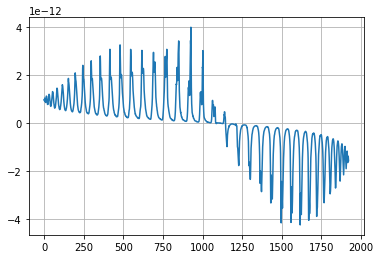

In [27]:
plt.plot(Phi_analytical)
plt.grid()

## Task 2: The effect of the non-linear transfer function: simulation (5 points)


**Tasks:**

a) Write a function simulating a sine-wave $x(t)=a*sin(\omega t)+b=a*sin(2\pi f t)+b$. Simulate a time interval of 10s with a sampling rate of fs=200Hz and plot it over the first $0.5s$ with $a=1$ for the amplitude, $b=0$ for the offset and $f=10Hz$ for the frequency.

b) Calculate the Power-Spectral-Density (PSD) of the signal and plot it over the frequency. For calculating the PSD, use the welch algorithm (scipy.signal.welch) and plot it using a logarithmic scale (10*log10(Pxx)). Clip the PSD at -80dB. Use a 10s snippet of the signal for calculating the PSD.

c) Use the logistic function $y(x)=\frac{1}{1+e^{-ax}}$ on the signal $x(t)$ as a non-linear time-invariant amplitude transformation. Do this for all possible combinations of the following amplitudes and offsets of the sine wave: a={0.5, 1, 10} and b={-2,-1,0, 1, 2}. Calculate and plot the PSD as in b).

d) The signal in a) and b) is a pure sine wave, which as a fourier transform has a single peak in the frequency spectrum. Explain the differences to the PSD of the sine wave (b) and the effect of the non-linear transformation on the PSD (c).

In [113]:
def tone(time_axis, amplitude, offset, freq):
    return a*np.sin(2*np.pi*freq*t) + b

def plot_psd(x, duration, fs, clip_value):
    
    spectrum = signal.welch(x[0:int(duration*fs)], fs)
    
    sp_in_log = 10*np.log10(spectrum[1])
    plt.plot(spectrum[0], sp_in_log)
    plt.ylim(clip_value, max(sp_in_log))
    plt.xlabel("Frequency in Hz")
    plt.ylabel("PSD (dB)")
    
def plot_time(x, time_axis, time_span, fs):

    plt.plot(time_axis[0:int(time_span*fs)], x[0:int(time_span*fs)])
    plt.xlabel("t(s)")
    plt.ylabel("Amplitude")

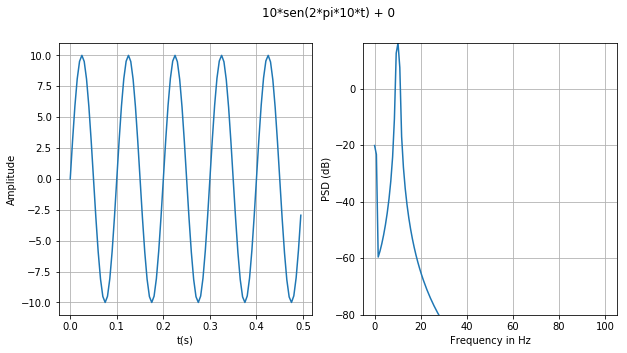

In [114]:
duration = 10
fs = 200
t = np.linspace(0, duration, fs*duration)
freq = 10
a = 10
b = 0
t_span = 0.5

x = tone(t, a, b, 10)
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plot_time(x, t, t_span, fs)
plt.grid()
plt.subplot(1, 2, 2)
plot_psd(x, 10, fs, -80)
plt.suptitle(f"{a}*sen(2*pi*10*t) + {b}")
plt.grid()
plt.show()

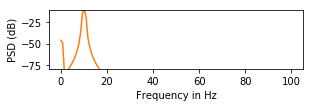

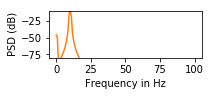

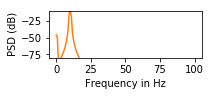

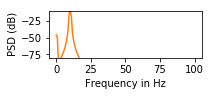

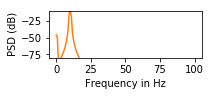

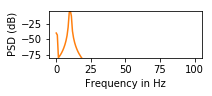

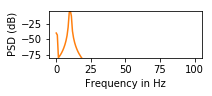

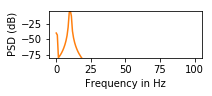

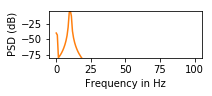

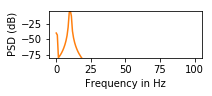

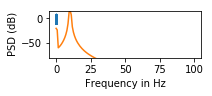

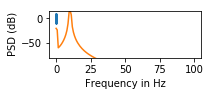

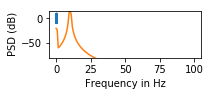

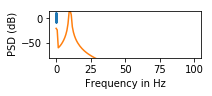

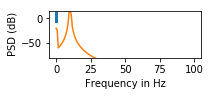

In [120]:
a_array = [0.5, 1, 10]
b_array = [-2, -1, 0, 1, 2]

plt.figure(figsize = (10, 5))

for ind_a, a in enumerate(a_array):
    for ind_b, b in enumerate(b_array):
        
        x = tone(t, a, b, 10)
        plt.subplot(4, 2, ind_a+ind_b+1)
        plot_time(x, t, t_span, fs)
        plt.grid()
        plt.subplot(4, 2, ind_a+ind_b+1)
        plot_psd(x, 10, fs, -80)
        #plt.suptitle(f"{a}*sen(2*pi*10*t) + {b}")
        plt.grid()
        plt.show()

In [40]:
spectrum[0]

array([  0.     ,   0.78125,   1.5625 ,   2.34375,   3.125  ,   3.90625,
         4.6875 ,   5.46875,   6.25   ,   7.03125,   7.8125 ,   8.59375,
         9.375  ,  10.15625,  10.9375 ,  11.71875,  12.5    ,  13.28125,
        14.0625 ,  14.84375,  15.625  ,  16.40625,  17.1875 ,  17.96875,
        18.75   ,  19.53125,  20.3125 ,  21.09375,  21.875  ,  22.65625,
        23.4375 ,  24.21875,  25.     ,  25.78125,  26.5625 ,  27.34375,
        28.125  ,  28.90625,  29.6875 ,  30.46875,  31.25   ,  32.03125,
        32.8125 ,  33.59375,  34.375  ,  35.15625,  35.9375 ,  36.71875,
        37.5    ,  38.28125,  39.0625 ,  39.84375,  40.625  ,  41.40625,
        42.1875 ,  42.96875,  43.75   ,  44.53125,  45.3125 ,  46.09375,
        46.875  ,  47.65625,  48.4375 ,  49.21875,  50.     ,  50.78125,
        51.5625 ,  52.34375,  53.125  ,  53.90625,  54.6875 ,  55.46875,
        56.25   ,  57.03125,  57.8125 ,  58.59375,  59.375  ,  60.15625,
        60.9375 ,  61.71875,  62.5    ,  63.28125, 

## Task 3: The effect of the non-linear transfer function: analytic & simulation (5 points)

With a little trick, the clipping of an oscillating signal like a cosine wave y(t) can be seen as a linear operation: the multiplication with a rectangular oscillation x(t) of same frequency and apropriate phase. We ignore the DC part in this exercise. This models the "on/off" effect of the clipping:

$z(t)=x(t)y(t)$

For the periodic rectangular time series defined within a period $T_0=\frac{1}{f_0}$ (note that this is a little bit different than in the lecture):

$x (t) = \left\{
\begin{array}{ll}
1  & \, \textrm{for} \left|t\right| \leq T_1 \\
0 & \, \textrm{else} \\
\end{array}
\right.$

the corresponding fourier transform (here one-sided) is based on the delta function:

$\hat{x}(f)=\frac{T_1}{T_0} \delta(f)+\sum_{n=1}^\infty \frac{\sin^2(\pi n\frac{T_1}{T_0})}{\pi n} \delta(f-\frac{n}{T_0})$

A cosine wave of frequency $f_0$ has the fourier transform:

$\hat{y}(f)=2 \pi \delta (f-f_0)$

In the theory of Fourier Transformation, a multiplicatiion in time domain corresponds to a convolution in the frequency:

$z(t)=x(t)y(t) <=> z(f)=\hat{x}(f) * \hat{y}(f)$

with the convolution being:

$\hat{x}(f)*\hat{y}(f)=\int_{-\infty}^{\infty}\hat{x}(f-f')\hat{y}(f')df'$

**Task:**

a) Calculate the Fourier Transform $\hat{z}(f)$ of the signal $z(t)$ analyitcally by convolving $\hat{x}(f)$ and $\hat{y}(f)$ in the frequency domain.

b) Implement the corresponding function for plotting and plot the amplitde spectrum for a clipped 10Hz. Set $T_1$ consequently to $\frac{1}{4}T_0$, $\frac{1}{2}T_0$ and $\frac{3}{4}T_0$. Plot the delta function using the matplot functiion stem. What are the corresponding clipping values?

c) Investigate the values at $nf_0$ and their dependency on the frequency.
What is the effect of the clipping in the spectrum? What implications does the non-linear effect of clipping have on clipped sine waves (single frequency peaks) and white noise (spectrum is constant over frequency)?


*Hint: For the convolution, think about the special properties of the dirac delta function $\delta(x)$.

Solution to a):

$\hat{z}(f)=$